In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.special import expit
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,make_scorer,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
ss=StandardScaler()

In [4]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
import random

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
le=LabelEncoder()

In [20]:
class TrainAuto:
    def __init__(self, dataset):
        
        #preprocessing step- setting up scaling for datasets which need them
        
        self.data=dataset
        self.scale=False
        
    def Traindata(self):
        column_titles=['Target']
        dft=pd.read_csv(self.data)
        
        #preprocessing step- changing the labels and deleting unwanted columns
        
        if ('Label' in dft.columns):
            dft['Label']=le.fit_transform(dft['Label'])
            dft.loc[dft['Label'] == 1, "Target"] = -1
            dft.loc[dft['Label'] == 0, "Target"] = 1
            dft.drop(['Label'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
        elif ('Class' in dft.columns):
            self.scale=False
            dft.loc[dft['Class'] == 1, "Target"] = -1
            dft.loc[dft['Class'] == 0, "Target"] = 1
            dft.drop(['Class','Time'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
        else:
            self.scale=True
            dft.dropna(axis=0,inplace=True)
            dft.reset_index(drop=True)
            let=LabelEncoder()
            dft['type']=let.fit_transform(dft['type'])
            dft.loc[dft['quality'].isin([3,4,5,6,7]),"Target"] = 1
            dft.loc[dft['quality'].isin([8,9]),"Target"] = -1
            dft.drop(['quality'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
            
        #using train-test split to create an appropriate split
        
        final_inliers = dft[dft['Target']==1]
        final_inliers_train, final_inliers_test = train_test_split(final_inliers, test_size=0.20, random_state=42)
        final_outlier = dft[dft['Target']==-1]
        len_outliers=final_outlier[:25]
        len_inliers=final_inliers_test[:18]
        
        #setting up validation set for hyper-parameter tuning
        
        if self.scale==False:
            final_val_set=pd.concat([len_outliers,len_inliers])
        else:
            final_val_set=pd.concat([len_outliers,len_inliers])
            final_val_set=pd.DataFrame(ss.fit_transform(final_val_set))
        if self.scale==False:
            final_train_scale=final_inliers_train.iloc[:,1:]
        else:
            final_train_scale=final_inliers_train.iloc[:,1:]
            final_train_scale=pd.DataFrame(ss.fit_transform(final_train_scale))
        final_test_scale=final_inliers_test.iloc[18:,1:]
        finoutlier_scale=final_outlier.iloc[25:,1:]
        yfin_test_in = final_inliers_test['Target'].iloc[18:]
        yfin_test_out = final_outlier['Target'].iloc[25:]
        y_fin_testval = pd.concat([yfin_test_in, yfin_test_out])
        y_fin_testval = np.array(y_fin_testval)
        if self.scale==False:
            df_fin_testval = pd.concat([final_test_scale,finoutlier_scale])
        else:
            df_fin_testval = pd.concat([final_test_scale,finoutlier_scale])
            df_fin_testval = pd.DataFrame(ss.fit_transform(df_fin_testval))  
        
        #returning the train, test and validation sets
        
        return final_train_scale,df_fin_testval,final_val_set,y_fin_testval
    
    def TuneData(self,val_set,train_set,df_test,y_test):
        
        #setting up parameters for OneClassSVM
        
        ocsvm_params = {'gamma' : ['scale','auto'], 'nu': [0.001,0.01,0.2,1], 'kernel':['poly','rbf','sigmoid','linear'],'degree':[3,5,8,10,12]}
        clf_ocsvm = GridSearchCV(OneClassSVM(), ocsvm_params, cv = 30, scoring='f1_micro')
        clf_ocsvm.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_fin=OneClassSVM(gamma=clf_ocsvm.best_params_['gamma'], nu=clf_ocsvm.best_params_['nu'],kernel=clf_ocsvm.best_params_['kernel'],degree=clf_ocsvm.best_params_['degree'])
        
        #Training model on the best parameters obtained
        model_fin.fit(train_set)
        
        #Setting up parameters for Isolation Forest
        isofor_params={'contamination' : [0.0017304750013189597,0.19055313859,0.19590178], 'n_estimators': [300], 'max_features':[5,6]}
        clf_isofor = GridSearchCV(IsolationForest(), isofor_params, cv = 30, scoring='f1_micro')
        clf_isofor.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_iso=IsolationForest(contamination=clf_isofor.best_params_['contamination'], n_estimators=clf_isofor.best_params_['n_estimators'],max_features=clf_isofor.best_params_['max_features'])
        
        #training model on the best parameters obtained
        model_iso.fit(train_set)
        
        #parameter dictionary for Elliptic Envelope
        
        ee_params={'contamination' : [0.2, 0.3, 0.19055313859,0.0017304750013189597], 'assume_centered': [True,False], 'support_fraction':[None,0.6,0.9]}
        clf_ee = GridSearchCV(EllipticEnvelope(), ee_params, cv = 30, scoring='f1_micro')
        clf_ee.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_ee=EllipticEnvelope(contamination=clf_ee.best_params_['contamination'], assume_centered=clf_ee.best_params_['assume_centered'],support_fraction=clf_ee.best_params_['support_fraction'])
        
        #training the elliptic envelope model on the best parameters
        
        model_ee.fit(train_set)
        
        #parameter dictionary for Local Outlier Factor
        lof_params={'contamination' : ['auto',0.0017304750013189597,0.3], 'n_neighbors': [14,30]}  
        clf_lof = GridSearchCV(LocalOutlierFactor(), lof_params, cv = 30, scoring='f1_micro')
        clf_lof.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_lof=LocalOutlierFactor(contamination=clf_lof.best_params_['contamination'],n_neighbors=clf_lof.best_params_['n_neighbors'],novelty=True)
        
        #training the Local Outlier Factor model on the best parameters obtained
        model_lof.fit(train_set)
        
        #returning the trained models in a list
        
        return [model_fin,model_iso,model_ee,model_lof]
    
    
    #Exp3 algorithm
    def exp3_base(self,X_test,y_test,model_list):
        
        #setting up learning rate
        l=np.log(2)
        lr = -(np.sqrt(l/4000))
        
        #Setting up psuedo loss
        losses = [[0,0,0,0]]
        todf=[]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)
        
        #to collect the predicted values
        pred=[]
        
        #to collect the actual values
        act=[]
        for t in range(1,100000):
            
            #list to maintain probability distribution for the current time-step
            cur_distribution = []
            
            #list to maintain the loss vector of the current time-step
            new_loss=[]
            
            #context vector for the current time-step
            
            dfrow=dftest.sample()
            
            #sum of exponential values of losses in the previous time-step for probabilty distribution
            
            sum_losses = np.sum([np.exp(s * lr) for s in losses[t-1]])
            
            #calulating the probability distribution for the current time-step
            
            for i in range(4):
                cur_distribution.append(np.exp(lr * losses[t-1][i]) / sum_losses)
            arm_probs = [(arm, cur_distribution[arm]) for arm in range(4)]
            
            #calling the choose_arm method to select the expert for the current time-step
            
            chosen_arm = self.choose_arm(arm_probs)
            
            #using get loss method to check the prediction for the context vector
            
            cur_loss,y_pred = self.get_loss(model_list,chosen_arm,dfrow.iloc[:,:-1],dfrow.iloc[:,-1].values[0])
            
            pred.append(y_pred)
            act.append(dfrow.iloc[:,-1].values[0])
            
            #creating the loss vector for the current time-step
            
            loss_vec= [0 if i!=chosen_arm else cur_loss for i in range(4)]
            
            #calculating the psuedo loss for the current time-step
            for i in range(4):
                new_loss.append(losses[t-1][i]+(loss_vec[i]/cur_distribution[i]))
            losses.append(new_loss)
            todf.append(cur_loss)
        
        #calulating the f1-score
        print("The f1-score of Exp3 is :",f1_score(pred,act))
        
        #return the list of losses to plot regret
        return todf
    
    #helper function for Exp3 to choose the expert for the given time-step
    def choose_arm(self,prob_value_list):
        arms = [tup[0] for tup in prob_value_list]
        probs = [float(tup[1]) for tup in prob_value_list]
        return random.choices(arms,weights=probs)[0]
    
    #helper function to check the loss against the actual y-label
    def get_loss(self,model_list,chosen_arm,X_test,y_test):
        y_pred = model_list[chosen_arm].predict(X_test)
        if y_pred==y_test:
            return 0,y_pred
        else:
            return 1,y_pred 
        
    #Exp4 Algorithm    
    def exp4_base(self,trial,X_test,y_test,model_list):
        
        #learning rate
        l=np.log(2)
        lr=-(np.sqrt(l/trial*2))
        
        #intial value for q vector that maintains the strength of experts
        q=[[1/4,1/4,1/4,1/4]]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)  
        todf=[]
        pred=[]
        act=[]
        
        for t in range(100000):
            psuedo_loss=[]
            newq=[]
            
            #getting the context vector for the current round
            dfrow=dftest.sample()
            
            #calling helper function to get expert advice
            
            exp_pred=self.exppred(model_list,dfrow.iloc[:,:-1])
            
            #Calculating the probability distribution for the time-step
            cur_distribution = np.dot(q[t],exp_pred)
            
            #calling function to find the loss against the true label value
            
            loss_vec,lpred= self.cur_loss(cur_distribution,dfrow.iloc[:,-1].values[0])
            
            #appending the loss values to a list to plot regret
            todf.append(loss_vec[0])
            act.append(dfrow.iloc[:,-1].values[0])
            pred.append(lpred)
            
            #Calculating the psuedo-loss
            for i in range(2):
                psuedo_loss.append(loss_vec[i]/cur_distribution[i])
            psuedo_loss=np.array(psuedo_loss)
            
            #Calculating the loss value with respect to each expert
            loss_cap=np.dot(exp_pred,psuedo_loss)
            
            nloss_cap=[]
            for i in range(4):
                nloss_cap.append(np.exp(loss_cap[i] * lr)*q[t][i])   
            sum_nloss=np.sum(nloss_cap)   
            #calculating the strength of experts for the next round
            for i in range(4):
                newq.append((np.exp(lr * loss_cap[i])*q[t][i])/sum_nloss)    
            q.append(newq)
        print("The f1-score of Exp4 is :",f1_score(act,pred))
        return todf

    #helper function to generate expert advice
    def exppred(self,model_list,X_test):
        newl=[]
        for x in range(4):
            sig=model_list[x].decision_function(X_test)
            newl.append([1-expit(sig)[0],expit(sig)[0]])
        newl=np.array(newl)
        return newl

    #helper function to check the loss
    def cur_loss(self,distb,y_test):
        label=[-1,1]
        prob=[distb[0],distb[1]]
        pred=random.choices(label,weights=prob)[0]
        if y_test==pred:
            return [0,0],pred
        else:
            return [1,1],pred
        
    #Batched Exp4    
    def exp4_batched(self,epoch,trial,X_test,y_test,model_list):
        
        #learning rate
        l=np.log(2)
        lr=-(np.sqrt(l/trial*2))
        
        #intial value for q vector that maintains the strength of experts
        q=[[1/4,1/4,1/4,1/4]]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)
        
        #List to maintain f1-scores from each epoch
        
        epochsuml=[]
        
        #epoch counter
        j=1
        
        while j<=(100000/epoch):
            todf=[]
            predb=[]
            actb=[]
            for t in range(100000):
                psuedo_loss=[]
                newq=[]
                
                #getting the context vector for the current round
                dfrow=dftest.sample()
                
                #calling helper function to get expert advice
                
                exp_pred=self.exppred(model_list,dfrow.iloc[:,:-1])
                
                #Calculating the probability distribution for the time-step
                
                cur_distribution = np.dot(q[t],exp_pred)
                
                #calling function to find the loss against the true label value
                
                loss_vec,lpredb= self.cur_loss(cur_distribution,dfrow.iloc[:,-1].values[0])
                
                #appending the predicted label value and actual value to check f1-score
                
                predb.append(lpredb)
                actb.append(dfrow.iloc[:,-1].values[0])
                
                #Calculating the psuedo-loss
                for i in range(2):
                    psuedo_loss.append(loss_vec[i]/cur_distribution[i])
                psuedo_loss=np.array(psuedo_loss)
                
                #Calculating the loss value with respect to each expert
                
                loss_cap=np.dot(exp_pred,psuedo_loss)
                nloss_cap=[]
                for i in range(4):
                    nloss_cap.append(np.exp(loss_cap[i] * lr)*q[t][i])  
                sum_nloss=np.sum(nloss_cap)
                
                #calculating the strength of experts for the next round
                for i in range(4):
                    newq.append((np.exp(lr * loss_cap[i])*q[t][i])/sum_nloss)
                q.append(newq)
                
            #calculating f1-score for epoch
            newfscore=f1_score(actb,predb)   
            epochsuml.append(newfscore)
            print('The f1-score for epoch '+str(j)+' is: ',newfscore)
            j=j+1
            
        #Calculating average f1-score across epcochs
        
        f1=sum(epochsuml)/len(epochsuml)
        print("The f1-score of Batched Exp4 is: ",f1)
        return epochsuml
    
    #helper function to plot regret
    def plot_regret_chart(self,loss,rounds,label):
        regret_loss=[]
        cumal_loss=np.cumsum(loss)
        for i in range(1,rounds):
            regret_loss.append(cumal_loss[i-1]/i)
        plt.plot(range(1,rounds),regret_loss,label=label)
        
    #Random Action Algorithm that picks experts randomly in every time-step    
    def random_action(self,X_test,y_test,model_list):
        lossl=[]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)  
        for t in range(100000):
            
            #Sampling the context vector for this time-step
            
            dfrow=dftest.sample()
            
            #Selecting a random expert for this time-step
            
            selectarm=random.choices(range(0,4))[0]
            
            ypred=model_list[selectarm].predict(dfrow.iloc[:,:-1])
            
            if ypred==dfrow.iloc[:,-1].values[0]:
                lossl.append(0)
            else:
                lossl.append(1)
        return lossl
        
    #Epsilon Greedy Algorithm
    def epsilon_greedy(self,epsilon,X_test,y_test,model_list):
        lossl=[]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)
        
        #list to maintain the average loss value of each expert
        
        qvalues=np.zeros(4)
        
        #list to maintain loss in each time-step
        
        lossval=np.zeros(4)
        
        #list to maintain the number of times each expert has been used
        
        armpull=np.zeros(4)
        lossl=[]
        for t in range(100000):
            
            #Collecting context-vector for each time-step
            
            dfrow=dftest.sample()
            
            #Exploration Route
            if np.random.random()<epsilon:
                pred=random.choices(range(0,4))[0]
                
            #Exploitation Route
            else:
                pred=np.argmin(qvalues)
            ypred=model_list[pred].predict(dfrow.iloc[:,:-1])
            if ypred==dfrow.iloc[:,-1].values[0]:
                curr_loss=0
            else:
                curr_loss=1
            lossval[pred]=lossval[pred]+curr_loss
            armpull[pred]=armpull[pred]+1
            qvalues[pred]=lossval[pred]/lossval[pred]
            lossl.append(curr_loss)
        return lossl
            
        

In [86]:
#checking Exp3 for Credit Card Dataset
sr=TrainAuto('creditcard.csv')
df_train,df_test,df_val,y_test=sr.Traindata()
mlist=sr.TuneData(df_val,df_train,df_test,y_test)
gh=sr.exp3_base(df_test,y_test,mlist)
jk=sr.random_action(df_test,y_test,mlist)
hk=sr.epsilon_greedy(0.01,df_test,y_test,mlist)

The f1-score of Exp3 is : 0.9942768552401757


In [87]:
#checking Exp3 for wine quality dataset
wq=TrainAuto('winequalityN.csv')
df_train,df_test,df_val,y_test=wq.Traindata()
mlist=wq.TuneData(df_val,df_train,df_test,y_test)
wq_exp3=wq.exp3_base(df_test,y_test,mlist)
wq_eps=wq.epsilon_greedy(0.01,df_test,y_test,mlist)
wq_random=wq.random_action(df_test,y_test,mlist)

The f1-score of Exp3 is : 0.932602324352315


In [88]:
#Checking Exp3 for Cardioctography dataset
cg=TrainAuto('cardio.csv')
df_train,df_test,df_val,y_test=cg.Traindata()
mlist=cg.TuneData(df_val,df_train,df_test,y_test)
cg_exp3=cg.exp3_base(df_test,y_test,mlist)
cg_eps=cg.epsilon_greedy(0.01,df_test,y_test,mlist)
cg_random=cg.random_action(df_test,y_test,mlist)

The f1-score of Exp3 is : 0.8596776597606102


In [89]:
#checking Exp3 for Mammography dataset
mg=TrainAuto('mammography.csv')
df_train,df_test,df_val,y_test=mg.Traindata()
mlist=mg.TuneData(df_val,df_train,df_test,y_test)
mg_exp3=mg.exp3_base(df_test,y_test,mlist)
mg_eps=mg.epsilon_greedy(0.01,df_test,y_test,mlist)
mg_random=mg.random_action(df_test,y_test,mlist)

The f1-score of Exp3 is : 0.9580050650956591


In [90]:
#Checking Exp3 for vertebral disease dataset
vd=TrainAuto('Vertebral.csv')
df_train,df_test,df_val,y_test=vd.Traindata()
mlist=vd.TuneData(df_val,df_train,df_test,y_test)
vd_exp3=vd.exp3_base(df_test,y_test,mlist)
vd_eps=vd.epsilon_greedy(0.01,df_test,y_test,mlist)
vd_random=vd.random_action(df_test,y_test,mlist)

The f1-score of Exp3 is : 0.9053736719087839


Text(0.5, 1.0, 'Credit Card Dataset')

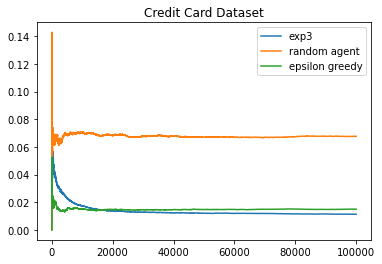

In [96]:
#plotting regret for Exp3 against random agent and epsilon-greedy for Credit-Card Dataset
sr.plot_regret_chart(gh,100000,label='exp3')
sr.plot_regret_chart(jk,100000,label='random agent')
sr.plot_regret_chart(hk,100000,label='epsilon greedy')
plt.legend()
plt.title('Credit Card Dataset')

Text(0.5, 1.0, 'Wine Quality Dataset')

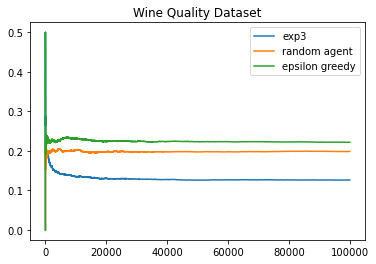

In [97]:
#plotting regret for Exp3 against random agent and epsilon-greedy for Wine Quality Dataset
wq.plot_regret_chart(wq_exp3,100000,label='exp3')
wq.plot_regret_chart(wq_random,100000,label='random agent')
wq.plot_regret_chart(wq_eps,100000,label='epsilon greedy')
plt.legend()
plt.title("Wine Quality Dataset")

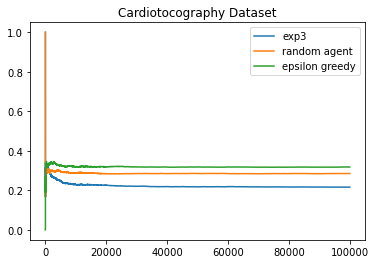

In [98]:
#plotting regret for Exp3 against random agent and epsilon-greedy for Cardiotocography Dataset
cg.plot_regret_chart(cg_exp3,100000,label='exp3')
cg.plot_regret_chart(cg_random,100000,label='random agent')
cg.plot_regret_chart(cg_eps,100000,label='epsilon greedy')
plt.title('Cardiotocography Dataset')
plt.legend()

Text(0.5, 1.0, 'Mammography Dataset')

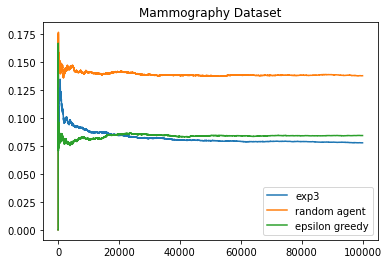

In [99]:
##plotting regret for Exp3 against random agent and epsilon-greedy for Mammography Dataset
mg.plot_regret_chart(mg_exp3,100000,label='exp3')
mg.plot_regret_chart(mg_random,100000,label='random agent')
mg.plot_regret_chart(mg_eps,100000,label='epsilon greedy')
plt.legend()
plt.title('Mammography Dataset')

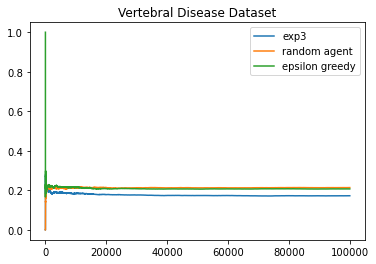

In [100]:
#plotting regret for Exp3 against random agent and epsilon-greedy for Vertebral Disease Dataset
vd.plot_regret_chart(vd_exp3,100000,label='exp3')
vd.plot_regret_chart(vd_random,100000,label='random agent')
vd.plot_regret_chart(vd_eps,100000,label='epsilon greedy')
plt.title('Vertebral Disease Dataset')
plt.legend()

In [91]:
#checking Exp4 for Mammography dataset
mg=TrainAuto('mammography.csv')
df_train,df_test,df_val,y_test=mg.Traindata()
mlist=mg.TuneData(df_val,df_train,df_test,y_test)
mg_exp4=mg.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp4 is : 0.9478564249367215


In [92]:
#checking Exp4 for Wine Quality dataset
wq=TrainAuto('winequalityN.csv')
df_train,df_test,df_val,y_test=wq.Traindata()
mlist=wq.TuneData(df_val,df_train,df_test,y_test)
wq_exp4=wq.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp4 is : 0.9333461370207954


In [93]:
#checking Exp4 for Vertebral Disease dataset
vd=TrainAuto('Vertebral.csv')
df_train,df_test,df_val,y_test=vd.Traindata()
mlist=vd.TuneData(df_val,df_train,df_test,y_test)
vd_exp4=vd.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp4 is : 0.9048325712564685


In [94]:
#checking Exp4 for Credit-Card dataset
cc=TrainAuto('creditcard.csv')
df_train,df_test,df_val,y_test=cc.Traindata()
mlist=cc.TuneData(df_val,df_train,df_test,y_test)
cc_exp4=cc.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp4 is : 0.9954997940753985


In [95]:
#checking Exp4 for Cardioctography dataset
cg=TrainAuto('cardio.csv')
df_train,df_test,df_val,y_test=cg.Traindata()
mlist=cg.TuneData(df_val,df_train,df_test,y_test)
cg_exp4=cg.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp4 is : 0.805675995270004


Text(0.5, 1.0, 'Credit Card Dataset')

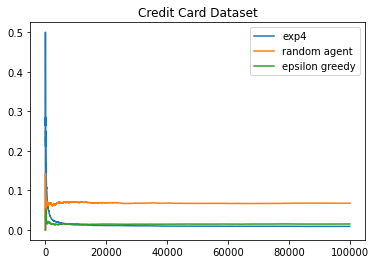

In [101]:
#plotting regret for Exp4 against random agent and epsilon-greedy for Credit-Card Dataset
cc.plot_regret_chart(cc_exp4,100000,label='exp4')
sr.plot_regret_chart(jk,100000,label='random agent')
sr.plot_regret_chart(hk,100000,label='epsilon greedy')
plt.legend()
plt.title('Credit Card Dataset')

Text(0.5, 1.0, 'Wine Quality Dataset')

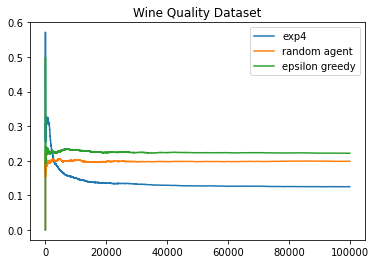

In [102]:
#plotting regret for Exp4 against random agent and epsilon-greedy for Wine Quality Dataset
wq.plot_regret_chart(wq_exp4,100000,label='exp4')
wq.plot_regret_chart(wq_random,100000,label='random agent')
wq.plot_regret_chart(wq_eps,100000,label='epsilon greedy')
plt.legend()
plt.title("Wine Quality Dataset")

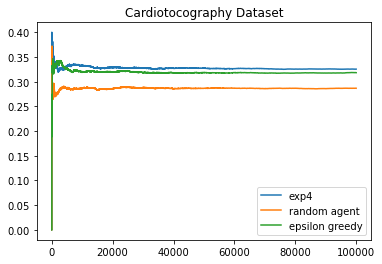

In [113]:
#plotting regret for Exp4 against random agent and epsilon-greedy for Cardiotocography Dataset
cg.plot_regret_chart(cg_exp4,100000,label='exp4')
cg.plot_regret_chart(cg_random,100000,label='random agent')
cg.plot_regret_chart(cg_eps,100000,label='epsilon greedy')
plt.title('Cardiotocography Dataset')
plt.legend()

Text(0.5, 1.0, 'Mammography Dataset')

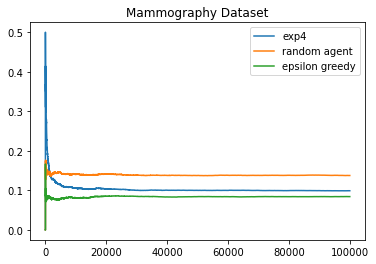

In [104]:
##plotting regret for Exp4 against random agent and epsilon-greedy for Mammography Dataset
mg.plot_regret_chart(mg_exp4,100000,label='exp4')
mg.plot_regret_chart(mg_random,100000,label='random agent')
mg.plot_regret_chart(mg_eps,100000,label='epsilon greedy')
plt.legend()
plt.title('Mammography Dataset')

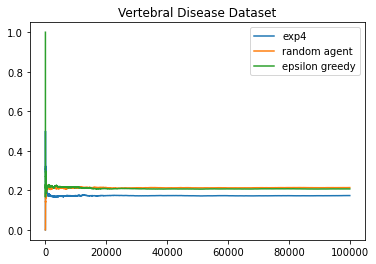

In [105]:
#plotting regret for Exp4 against random agent and epsilon-greedy for Vertebral Disease Dataset
vd.plot_regret_chart(vd_exp4,100000,label='exp4')
vd.plot_regret_chart(vd_random,100000,label='random agent')
vd.plot_regret_chart(vd_eps,100000,label='epsilon greedy')
plt.title('Vertebral Disease Dataset')
plt.legend()

In [11]:
#Batched Exp4 performance Evaluation using Credit Card Dataset
cc=TrainAuto('creditcard.csv')
df_train,df_test,df_val,y_test=cc.Traindata()
mlist=cc.TuneData(df_val,df_train,df_test,y_test)
cc_exp4_b=cc.exp4_batched(25000,200,df_test,y_test,mlist)

The f1-score for epoch 1 is:  0.9958578723019686
The f1-score for epoch 2 is:  0.995993935682085
The f1-score for epoch 3 is:  0.9955905543446599
The f1-score for epoch 4 is:  0.9957570736361125
The f1-score of Batched Exp4 is:  0.9957998589912065


In [12]:
#Batched Exp4 performance Evaluation using Vertebral Diseases Dataset
vd=TrainAuto('Vertebral.csv')
df_train,df_test,df_val,y_test=vd.Traindata()
mlist=vd.TuneData(df_val,df_train,df_test,y_test)
vd_exp4_b=vd.exp4_batched(25000,200,df_test,y_test,mlist)

The f1-score for epoch 1 is:  0.9065570274954483
The f1-score for epoch 2 is:  0.9058191447454808
The f1-score for epoch 3 is:  0.9052610835281173
The f1-score for epoch 4 is:  0.905407772304324
The f1-score of Batched Exp4 is:  0.9057612570183425


In [13]:
#Batched Exp4 performance Evaluation using Mammography Dataset
mg=TrainAuto('mammography.csv')
df_train,df_test,df_val,y_test=mg.Traindata()
mlist=mg.TuneData(df_val,df_train,df_test,y_test)
mg_exp4_b=mg.exp4_batched(25000,200,df_test,y_test,mlist)

The f1-score for epoch 1 is:  0.9489144719550019
The f1-score for epoch 2 is:  0.9475540302969693
The f1-score for epoch 3 is:  0.9477357050759151
The f1-score for epoch 4 is:  0.9483566593559177
The f1-score of Batched Exp4 is:  0.948140216670951


In [14]:
#Batched Exp4 performance Evaluation using Wine Quality Dataset
wq=TrainAuto('winequalityN.csv')
df_train,df_test,df_val,y_test=wq.Traindata()
mlist=wq.TuneData(df_val,df_train,df_test,y_test)
wq_exp4_b=wq.exp4_batched(25000,200,df_test,y_test,mlist)

The f1-score for epoch 1 is:  0.9336902844587603
The f1-score for epoch 2 is:  0.9337748697520889
The f1-score for epoch 3 is:  0.9348425930858147
The f1-score for epoch 4 is:  0.9343090592204497
The f1-score of Batched Exp4 is:  0.9341542016292784


In [ ]:
###Batched Exp4 evaluation for Cardiotocography dataset is executed in the notebook 'Batched Exp4 Cardiotocography'

In [21]:
cc=TrainAuto('creditcard.csv')
df_train,df_test,df_val,y_test=cc.Traindata()
mlist=cc.TuneData(df_val,df_train,df_test,y_test)
cc_exp3=cc.exp3_base(df_test,y_test,mlist)
cc_exp4=cc.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp3 is : 0.9942627075993961
The f1-score of Exp4 is : 0.9957015165210404


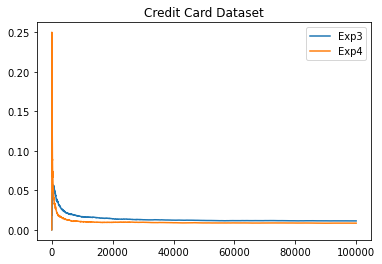

In [22]:
#Plotting regret for Exp3 and Exp4 for Credit Card Dataset
cc.plot_regret_chart(cc_exp3,100000,label='Exp3')
cc.plot_regret_chart(cc_exp4,100000,label='Exp4')
plt.title('Credit Card Dataset')
plt.legend()

In [23]:
wq=TrainAuto('winequalityN.csv')
df_train,df_test,df_val,y_test=wq.Traindata()
mlist=wq.TuneData(df_val,df_train,df_test,y_test)
wq_exp3=wq.exp3_base(df_test,y_test,mlist)
wq_exp4=wq.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp3 is : 0.9329939269742671
The f1-score of Exp4 is : 0.9344621269839578


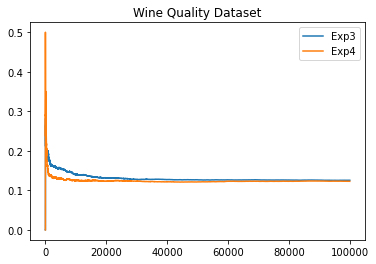

In [24]:
#Plotting regret for Exp3 and Exp4 for Wine Quality Dataset
wq.plot_regret_chart(wq_exp3,100000,label='Exp3')
wq.plot_regret_chart(wq_exp4,100000,label='Exp4')
plt.title('Wine Quality Dataset')
plt.legend()

In [25]:
cg=TrainAuto('cardio.csv')
df_train,df_test,df_val,y_test=cg.Traindata()
mlist=cg.TuneData(df_val,df_train,df_test,y_test)
cg_exp3=cg.exp3_base(df_test,y_test,mlist)
cg_exp4=cg.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp3 is : 0.8587384763415554
The f1-score of Exp4 is : 0.8050309204433425


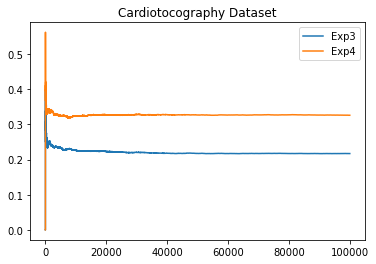

In [26]:
#Plotting regret for Exp3 and Exp4 for Cardiotocography Dataset
cg.plot_regret_chart(cg_exp3,100000,label='Exp3')
cg.plot_regret_chart(cg_exp4,100000,label='Exp4')
plt.title('Cardiotocography Dataset')
plt.legend()

In [27]:
mg=TrainAuto('mammography.csv')
df_train,df_test,df_val,y_test=mg.Traindata()
mlist=mg.TuneData(df_val,df_train,df_test,y_test)
mg_exp3=mg.exp3_base(df_test,y_test,mlist)
mg_exp4=mg.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp3 is : 0.9589322160189194
The f1-score of Exp4 is : 0.9486793960550112


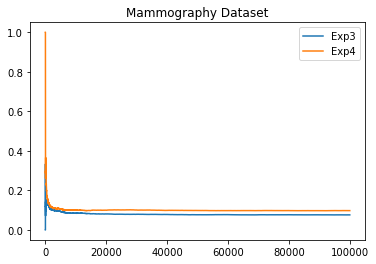

In [28]:
#Plotting regret for Exp3 and Exp4 for Mammography Dataset
mg.plot_regret_chart(mg_exp3,100000,label='Exp3')
mg.plot_regret_chart(mg_exp4,100000,label='Exp4')
plt.title('Mammography Dataset')
plt.legend()

In [29]:
vd=TrainAuto('Vertebral.csv')
df_train,df_test,df_val,y_test=vd.Traindata()
mlist=vd.TuneData(df_val,df_train,df_test,y_test)
vd_exp3=vd.exp3_base(df_test,y_test,mlist)
vd_exp4=vd.exp4_base(200,df_test,y_test,mlist)

The f1-score of Exp3 is : 0.9036453050729445
The f1-score of Exp4 is : 0.904618721348647


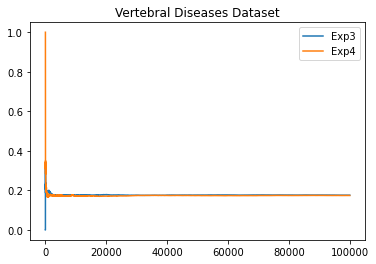

In [30]:
#Plotting regret for Exp3 and Exp4 for Vertebral Diseases Dataset
vd.plot_regret_chart(vd_exp3,100000,label='Exp3')
vd.plot_regret_chart(vd_exp4,100000,label='Exp4')
plt.title('Vertebral Diseases Dataset')
plt.legend()